# Chest X-Ray Image Generation using VAE

This notebook illustrates how to use the VAE module to generate X-Ray images, including the new features for conditional generation based on patient features.

We will take the COVID-19 CXR dataset as starting point. This dataset is freely available on Kaggle and contains images of Chest X-Rays from COVID-19 patients.

## Download Data

Data is available from Kaggle. If it is not already available locally, download it with the following command:

In [21]:
# Download command (uncomment to run)
# !curl -L -o ~/Downloads/covid19-radiography-database.zip https://www.kaggle.com/api/v1/datasets/download/tawsifurrahman/covid19-radiography-database
# !unzip ~/Downloads/covid19-radiography-database.zip -d ~/Downloads/COVID-19_Radiography_Dataset

## Load Data with PyHealth Datasets

Use the COVID19CXRDataset to load this data. For custom datasets, see the `BaseImageDataset` class.

In [22]:
from pyhealth.datasets import split_by_visit, get_dataloader
from pyhealth.trainer import Trainer
from pyhealth.datasets import COVID19CXRDataset
from pyhealth.models import VAE
from pyhealth.processors import ImageProcessor
from torchvision import transforms

import torch
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# Step 1: Load data
root = "/home/ubuntu/Downloads/COVID-19_Radiography_Dataset"
base_dataset = COVID19CXRDataset(root)

# Step 2: Set task with custom image processing for VAE
image_processor = ImageProcessor(image_size=128, mode="L")  # Resize to 128x128 for VAE
sample_dataset = base_dataset.set_task(input_processors={"image": image_processor})

No config path provided, using default config
Initializing covid19_cxr dataset from /home/ubuntu/Downloads/COVID-19_Radiography_Dataset (dev mode: False)
Scanning table: covid19_cxr from /home/ubuntu/Downloads/COVID-19_Radiography_Dataset/covid19_cxr-metadata-pyhealth.csv
Setting task COVID19CXRClassification for covid19_cxr base dataset...
Generating samples with 1 worker(s)...
Collected dataframe with shape: (21165, 6)


Generating samples for COVID19CXRClassification with 1 worker: 100%|██████████| 21165/21165 [00:07<00:00, 2647.56it/s]

Label disease vocab: {'COVID': 0, 'Lung Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}



Processing samples: 100%|██████████| 21165/21165 [00:34<00:00, 612.25it/s]

Generated 21165 samples for task COVID19CXRClassification


In [55]:
!ls ~/Downloads/COVID-19_Radiography_Dataset//COVID/images/COVID-1.png 

/home/ubuntu/Downloads/COVID-19_Radiography_Dataset//COVID/images/COVID-1.png


In [57]:
base_dataset.prepare_metadata("/home/ubuntu/Downloads/COVID-19_Radiography_Dataset")

In [49]:
covid_metadata = base_dataset.load_table('covid19_cxr')
covid_metadata.collect()

Scanning table: covid19_cxr from /home/ubuntu/Downloads/COVID-19_Radiography_Dataset/covid19_cxr-metadata-pyhealth.csv


patient_id,event_type,timestamp,covid19_cxr/path,covid19_cxr/url,covid19_cxr/label
str,str,datetime[ms],str,str,str
"""0""","""covid19_cxr""",null,"""/home/ubuntu/Downloads/COVID-1…","""https://sirm.org/category/senz…","""COVID"""
"""1""","""covid19_cxr""",null,"""/home/ubuntu/Downloads/COVID-1…","""https://sirm.org/category/senz…","""COVID"""
"""2""","""covid19_cxr""",null,"""/home/ubuntu/Downloads/COVID-1…","""https://sirm.org/category/senz…","""COVID"""
"""3""","""covid19_cxr""",null,"""/home/ubuntu/Downloads/COVID-1…","""https://sirm.org/category/senz…","""COVID"""
"""4""","""covid19_cxr""",null,"""/home/ubuntu/Downloads/COVID-1…","""https://sirm.org/category/senz…","""COVID"""
…,…,…,…,…,…
"""21160""","""covid19_cxr""",null,"""/home/ubuntu/Downloads/COVID-1…","""https://www.kaggle.com/paultim…","""Viral Pneumonia"""
"""21161""","""covid19_cxr""",null,"""/home/ubuntu/Downloads/COVID-1…","""https://www.kaggle.com/paultim…","""Viral Pneumonia"""
"""21162""","""covid19_cxr""",null,"""/home/ubuntu/Downloads/COVID-1…","""https://www.kaggle.com/paultim…","""Viral Pneumonia"""


In [36]:
dir(base_dataset)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_raw_data_exists',
 '_collected_global_event_df',
 '_unique_patient_ids',
 'collected_global_event_df',
 'config',
 'dataset_name',
 'default_task',
 'dev',
 'get_patient',
 'global_event_df',
 'iter_patients',
 'load_data',
 'load_table',
 'prepare_metadata',
 'root',
 'set_task',
 'stats',
 'tables',
 'unique_patient_ids']

In [34]:
dir(sample_dataset)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_processor_instance',
 'build',
 'dataset_name',
 'input_processors',
 'input_schema',
 'output_processors',
 'output_schema',
 'patient_to_index',
 'record_to_index',
 'samples',
 'task_name',
 'validate']

In [24]:
# Split dataset
train_dataset, val_dataset, test_dataset = split_by_visit(
    sample_dataset, [0.6, 0.2, 0.2]
)
train_dataloader = get_dataloader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = get_dataloader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = get_dataloader(test_dataset, batch_size=256, shuffle=False)

# Check data
data = next(iter(train_dataloader))
print("Data keys:", data.keys())
print("Image shape:", data["image"][0].shape)
print(f"Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Data keys: dict_keys(['image', 'disease'])
Image shape: torch.Size([1, 128, 128])
Dataset sizes - Train: 12699, Val: 4233, Test: 4233


## Basic VAE Training (Image Generation)

Train a standard VAE for unconditional image generation.

Note: since this notebook is just a demo, we will only run 5 epochs. Image generation will work much better if the VAE is trained for longer.

In [25]:
# Define model
model = VAE(
    dataset=sample_dataset,
    feature_keys=["image"],
    label_key="image",
    mode="regression",
    input_type="image",
    input_channel=1,  # Grayscale images from COVID dataset
    input_size=128,
    hidden_dim=128,
)

# Define trainer
trainer = Trainer(model=model, device="cuda" if torch.cuda.is_available() else "cpu", 
                 metrics=["kl_divergence", "mse", "mae"])

# Train (reduce epochs for demo)
trainer.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=100,  # Reduced for demo
    monitor="kl_divergence",
    monitor_criterion="min",
    optimizer_params={"lr": 1e-3},
)

VAE(
  (encoder1): Sequential(
    (0): ResBlock2D(
      (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ELU(alpha=1.0)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (downsampler): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): ResBlock2D(
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ELU(al

Epoch 0 / 100: 100%|██████████| 50/50 [00:01<00:00, 35.45it/s]

--- Train epoch-0, step-50 ---
loss: 2711011.5000



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.05it/s]


--- Eval epoch-0, step-50 ---
kl_divergence: 0.2400
mse: 0.0000
mae: 0.0000
loss: 2529554.5294
New best kl_divergence score (0.2400) at epoch-0, step-50



Epoch 1 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.37it/s]

--- Train epoch-1, step-100 ---
loss: 2484871.7750



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.15it/s]


--- Eval epoch-1, step-100 ---
kl_divergence: 0.1235
mse: 0.0000
mae: 0.0000
loss: 2399533.6471
New best kl_divergence score (0.1235) at epoch-1, step-100



Epoch 2 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.35it/s]

--- Train epoch-2, step-150 ---
loss: 2441498.8750



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.16it/s]


--- Eval epoch-2, step-150 ---
kl_divergence: 0.0947
mse: 0.0000
mae: 0.0000
loss: 2374399.9338
New best kl_divergence score (0.0947) at epoch-2, step-150



Epoch 3 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.31it/s]

--- Train epoch-3, step-200 ---
loss: 2420913.6700



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 37.84it/s]


--- Eval epoch-3, step-200 ---
kl_divergence: 0.0766
mse: 0.0000
mae: 0.0000
loss: 2354166.8382
New best kl_divergence score (0.0766) at epoch-3, step-200



Epoch 4 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.45it/s]

--- Train epoch-4, step-250 ---
loss: 2408058.0250



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.11it/s]


--- Eval epoch-4, step-250 ---
kl_divergence: 0.0780
mse: 0.0000
mae: 0.0000
loss: 2346614.8309



Epoch 5 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.49it/s]

--- Train epoch-5, step-300 ---
loss: 2399625.5950



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 37.99it/s]


--- Eval epoch-5, step-300 ---
kl_divergence: 0.0596
mse: 0.0000
mae: 0.0000
loss: 2334301.7279
New best kl_divergence score (0.0596) at epoch-5, step-300



Epoch 6 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.35it/s]

--- Train epoch-6, step-350 ---
loss: 2390977.9250



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.08it/s]


--- Eval epoch-6, step-350 ---
kl_divergence: 0.0692
mse: 0.0000
mae: 0.0000
loss: 2336474.9632



Epoch 7 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.40it/s]

--- Train epoch-7, step-400 ---
loss: 2385963.7100



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.12it/s]


--- Eval epoch-7, step-400 ---
kl_divergence: 0.0486
mse: 0.0000
mae: 0.0000
loss: 2323853.6029
New best kl_divergence score (0.0486) at epoch-7, step-400



Epoch 8 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.38it/s]

--- Train epoch-8, step-450 ---
loss: 2380930.9825



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.17it/s]


--- Eval epoch-8, step-450 ---
kl_divergence: 0.0510
mse: 0.0000
mae: 0.0000
loss: 2322110.7647



Epoch 9 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.37it/s]

--- Train epoch-9, step-500 ---
loss: 2379506.1100



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.06it/s]


--- Eval epoch-9, step-500 ---
kl_divergence: 0.0450
mse: 0.0000
mae: 0.0000
loss: 2318578.3603
New best kl_divergence score (0.0450) at epoch-9, step-500



Epoch 10 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.25it/s]

--- Train epoch-10, step-550 ---
loss: 2374264.3100



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.17it/s]


--- Eval epoch-10, step-550 ---
kl_divergence: 0.0400
mse: 0.0000
mae: 0.0000
loss: 2314281.8235
New best kl_divergence score (0.0400) at epoch-10, step-550



Epoch 11 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.38it/s]

--- Train epoch-11, step-600 ---
loss: 2372513.5975



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.12it/s]


--- Eval epoch-11, step-600 ---
kl_divergence: 0.0491
mse: 0.0000
mae: 0.0000
loss: 2328055.8824



Epoch 12 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.33it/s]

--- Train epoch-12, step-650 ---
loss: 2370949.2325



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.11it/s]


--- Eval epoch-12, step-650 ---
kl_divergence: 0.0445
mse: 0.0000
mae: 0.0000
loss: 2309963.8676



Epoch 13 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.37it/s]

--- Train epoch-13, step-700 ---
loss: 2366677.5600



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.10it/s]


--- Eval epoch-13, step-700 ---
kl_divergence: 0.0430
mse: 0.0000
mae: 0.0000
loss: 2309238.5735



Epoch 14 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.27it/s]

--- Train epoch-14, step-750 ---
loss: 2363773.9425



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 35.83it/s]


--- Eval epoch-14, step-750 ---
kl_divergence: 0.0350
mse: 0.0000
mae: 0.0000
loss: 2307568.5221
New best kl_divergence score (0.0350) at epoch-14, step-750



Epoch 15 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.40it/s]

--- Train epoch-15, step-800 ---
loss: 2362592.3750



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 37.42it/s]


--- Eval epoch-15, step-800 ---
kl_divergence: 0.0366
mse: 0.0000
mae: 0.0000
loss: 2306792.4265



Epoch 16 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.46it/s]

--- Train epoch-16, step-850 ---
loss: 2360815.9850



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.08it/s]


--- Eval epoch-16, step-850 ---
kl_divergence: 0.0382
mse: 0.0000
mae: 0.0000
loss: 2302891.6103



Epoch 17 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.42it/s]

--- Train epoch-17, step-900 ---
loss: 2360719.1925



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 37.86it/s]


--- Eval epoch-17, step-900 ---
kl_divergence: 0.0474
mse: 0.0000
mae: 0.0000
loss: 2307161.1176



Epoch 18 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.41it/s]

--- Train epoch-18, step-950 ---
loss: 2359394.6375



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.22it/s]


--- Eval epoch-18, step-950 ---
kl_divergence: 0.0409
mse: 0.0000
mae: 0.0000
loss: 2312827.6250



Epoch 19 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.33it/s]

--- Train epoch-19, step-1000 ---
loss: 2360602.6425



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.10it/s]


--- Eval epoch-19, step-1000 ---
kl_divergence: 0.0348
mse: 0.0000
mae: 0.0000
loss: 2299844.1985
New best kl_divergence score (0.0348) at epoch-19, step-1000



Epoch 20 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.28it/s]

--- Train epoch-20, step-1050 ---
loss: 2357777.2925



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 37.95it/s]


--- Eval epoch-20, step-1050 ---
kl_divergence: 0.0321
mse: 0.0000
mae: 0.0000
loss: 2301801.5147
New best kl_divergence score (0.0321) at epoch-20, step-1050



Epoch 21 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.19it/s]

--- Train epoch-21, step-1100 ---
loss: 2356378.9725



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.13it/s]


--- Eval epoch-21, step-1100 ---
kl_divergence: 0.0339
mse: 0.0000
mae: 0.0000
loss: 2300178.7059



Epoch 22 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.31it/s]

--- Train epoch-22, step-1150 ---
loss: 2355426.1100



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.09it/s]


--- Eval epoch-22, step-1150 ---
kl_divergence: 0.0385
mse: 0.0000
mae: 0.0000
loss: 2301814.8309



Epoch 23 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.30it/s]

--- Train epoch-23, step-1200 ---
loss: 2356942.4100



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.06it/s]


--- Eval epoch-23, step-1200 ---
kl_divergence: 0.0327
mse: 0.0000
mae: 0.0000
loss: 2298483.8529



Epoch 24 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.37it/s]

--- Train epoch-24, step-1250 ---
loss: 2354826.7375



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 37.94it/s]


--- Eval epoch-24, step-1250 ---
kl_divergence: 0.0324
mse: 0.0000
mae: 0.0000
loss: 2305399.8382



Epoch 25 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.21it/s]

--- Train epoch-25, step-1300 ---
loss: 2355785.7650



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.02it/s]


--- Eval epoch-25, step-1300 ---
kl_divergence: 0.0322
mse: 0.0000
mae: 0.0000
loss: 2297033.0074



Epoch 26 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.14it/s]

--- Train epoch-26, step-1350 ---
loss: 2352483.1900



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.10it/s]


--- Eval epoch-26, step-1350 ---
kl_divergence: 0.0312
mse: 0.0000
mae: 0.0000
loss: 2295983.8529
New best kl_divergence score (0.0312) at epoch-26, step-1350



Epoch 27 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.46it/s]

--- Train epoch-27, step-1400 ---
loss: 2352934.1050



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.07it/s]


--- Eval epoch-27, step-1400 ---
kl_divergence: 0.0300
mse: 0.0000
mae: 0.0000
loss: 2299809.5662
New best kl_divergence score (0.0300) at epoch-27, step-1400



Epoch 28 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.40it/s]

--- Train epoch-28, step-1450 ---
loss: 2352002.1975



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 38.07it/s]


--- Eval epoch-28, step-1450 ---
kl_divergence: 0.0281
mse: 0.0000
mae: 0.0000
loss: 2295801.5074
New best kl_divergence score (0.0281) at epoch-28, step-1450



Epoch 29 / 100: 100%|██████████| 50/50 [00:01<00:00, 36.45it/s]

--- Train epoch-29, step-1500 ---
loss: 2351902.6075



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 37.44it/s]


--- Eval epoch-29, step-1500 ---
kl_divergence: 0.0297
mse: 0.0000
mae: 0.0000
loss: 2296136.4044



Epoch 30 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.26it/s]

--- Train epoch-30, step-1550 ---
loss: 2350518.8375



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.77it/s]


--- Eval epoch-30, step-1550 ---
kl_divergence: 0.0301
mse: 0.0000
mae: 0.0000
loss: 2295818.2426



Epoch 31 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.29it/s]

--- Train epoch-31, step-1600 ---
loss: 2351454.1575



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 35.18it/s]


--- Eval epoch-31, step-1600 ---
kl_divergence: 0.0334
mse: 0.0000
mae: 0.0000
loss: 2298161.6985



Epoch 32 / 100: 100%|██████████| 50/50 [00:01<00:00, 28.44it/s]

--- Train epoch-32, step-1650 ---
loss: 2351444.4650



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 35.52it/s]


--- Eval epoch-32, step-1650 ---
kl_divergence: 0.0274
mse: 0.0000
mae: 0.0000
loss: 2294795.2794
New best kl_divergence score (0.0274) at epoch-32, step-1650



Epoch 33 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.51it/s]

--- Train epoch-33, step-1700 ---
loss: 2349583.7525



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.68it/s]


--- Eval epoch-33, step-1700 ---
kl_divergence: 0.0298
mse: 0.0000
mae: 0.0000
loss: 2293530.4044



Epoch 34 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.46it/s]

--- Train epoch-34, step-1750 ---
loss: 2350700.9825



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.89it/s]


--- Eval epoch-34, step-1750 ---
kl_divergence: 0.0308
mse: 0.0000
mae: 0.0000
loss: 2294235.7353



Epoch 35 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.25it/s]

--- Train epoch-35, step-1800 ---
loss: 2348895.1675



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.84it/s]


--- Eval epoch-35, step-1800 ---
kl_divergence: 0.0287
mse: 0.0000
mae: 0.0000
loss: 2292043.6544



Epoch 36 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.21it/s]

--- Train epoch-36, step-1850 ---
loss: 2351366.5725



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.49it/s]


--- Eval epoch-36, step-1850 ---
kl_divergence: 0.0329
mse: 0.0000
mae: 0.0000
loss: 2297428.5147



Epoch 37 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.40it/s]

--- Train epoch-37, step-1900 ---
loss: 2350561.4350



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.54it/s]


--- Eval epoch-37, step-1900 ---
kl_divergence: 0.0292
mse: 0.0000
mae: 0.0000
loss: 2294171.5588



Epoch 38 / 100: 100%|██████████| 50/50 [00:01<00:00, 28.54it/s]

--- Train epoch-38, step-1950 ---
loss: 2348130.0575



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 35.46it/s]


--- Eval epoch-38, step-1950 ---
kl_divergence: 0.0268
mse: 0.0000
mae: 0.0000
loss: 2294876.7941
New best kl_divergence score (0.0268) at epoch-38, step-1950



Epoch 39 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.43it/s]

--- Train epoch-39, step-2000 ---
loss: 2347672.2275



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.62it/s]


--- Eval epoch-39, step-2000 ---
kl_divergence: 0.0263
mse: 0.0000
mae: 0.0000
loss: 2293266.8676
New best kl_divergence score (0.0263) at epoch-39, step-2000



Epoch 40 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.41it/s]

--- Train epoch-40, step-2050 ---
loss: 2347195.6550



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.76it/s]


--- Eval epoch-40, step-2050 ---
kl_divergence: 0.0281
mse: 0.0000
mae: 0.0000
loss: 2291784.0368



Epoch 41 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.19it/s]

--- Train epoch-41, step-2100 ---
loss: 2346986.0900



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.55it/s]


--- Eval epoch-41, step-2100 ---
kl_divergence: 0.0282
mse: 0.0000
mae: 0.0000
loss: 2291543.7206



Epoch 42 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.28it/s]

--- Train epoch-42, step-2150 ---
loss: 2347493.9925



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 35.00it/s]


--- Eval epoch-42, step-2150 ---
kl_divergence: 0.0317
mse: 0.0000
mae: 0.0000
loss: 2300747.5809



Epoch 43 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.22it/s]

--- Train epoch-43, step-2200 ---
loss: 2347526.1150



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.67it/s]


--- Eval epoch-43, step-2200 ---
kl_divergence: 0.0283
mse: 0.0000
mae: 0.0000
loss: 2292120.6471



Epoch 44 / 100: 100%|██████████| 50/50 [00:01<00:00, 28.62it/s]

--- Train epoch-44, step-2250 ---
loss: 2346933.8000



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 35.45it/s]


--- Eval epoch-44, step-2250 ---
kl_divergence: 0.0293
mse: 0.0000
mae: 0.0000
loss: 2293257.6029



Epoch 45 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.44it/s]

--- Train epoch-45, step-2300 ---
loss: 2346743.1500



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.85it/s]


--- Eval epoch-45, step-2300 ---
kl_divergence: 0.0244
mse: 0.0000
mae: 0.0000
loss: 2293316.5809
New best kl_divergence score (0.0244) at epoch-45, step-2300



Epoch 46 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.32it/s]

--- Train epoch-46, step-2350 ---
loss: 2345746.6750



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.88it/s]


--- Eval epoch-46, step-2350 ---
kl_divergence: 0.0271
mse: 0.0000
mae: 0.0000
loss: 2292839.3015



Epoch 47 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.28it/s]

--- Train epoch-47, step-2400 ---
loss: 2346096.1700



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.90it/s]


--- Eval epoch-47, step-2400 ---
kl_divergence: 0.0291
mse: 0.0000
mae: 0.0000
loss: 2291262.6397



Epoch 48 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.24it/s]

--- Train epoch-48, step-2450 ---
loss: 2346403.4175



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.96it/s]


--- Eval epoch-48, step-2450 ---
kl_divergence: 0.0327
mse: 0.0000
mae: 0.0000
loss: 2292963.6985



Epoch 49 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.13it/s]

--- Train epoch-49, step-2500 ---
loss: 2345663.5900



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.64it/s]


--- Eval epoch-49, step-2500 ---
kl_divergence: 0.0281
mse: 0.0000
mae: 0.0000
loss: 2293881.8162



Epoch 50 / 100: 100%|██████████| 50/50 [00:01<00:00, 28.60it/s]

--- Train epoch-50, step-2550 ---
loss: 2345499.5350



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 35.46it/s]


--- Eval epoch-50, step-2550 ---
kl_divergence: 0.0311
mse: 0.0000
mae: 0.0000
loss: 2292226.6544



Epoch 51 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.19it/s]

--- Train epoch-51, step-2600 ---
loss: 2346476.8900



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.78it/s]


--- Eval epoch-51, step-2600 ---
kl_divergence: 0.0288
mse: 0.0000
mae: 0.0000
loss: 2292397.7794



Epoch 52 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.20it/s]

--- Train epoch-52, step-2650 ---
loss: 2345242.6850



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 35.15it/s]


--- Eval epoch-52, step-2650 ---
kl_divergence: 0.0253
mse: 0.0000
mae: 0.0000
loss: 2292180.9338



Epoch 53 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.31it/s]

--- Train epoch-53, step-2700 ---
loss: 2344865.1300



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.53it/s]


--- Eval epoch-53, step-2700 ---
kl_divergence: 0.0253
mse: 0.0000
mae: 0.0000
loss: 2290460.2574



Epoch 54 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.39it/s]

--- Train epoch-54, step-2750 ---
loss: 2343859.1975



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.82it/s]


--- Eval epoch-54, step-2750 ---
kl_divergence: 0.0281
mse: 0.0000
mae: 0.0000
loss: 2291312.9044



Epoch 55 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.33it/s]

--- Train epoch-55, step-2800 ---
loss: 2344955.8425



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.84it/s]


--- Eval epoch-55, step-2800 ---
kl_divergence: 0.0309
mse: 0.0000
mae: 0.0000
loss: 2290324.2721



Epoch 56 / 100: 100%|██████████| 50/50 [00:01<00:00, 28.06it/s]

--- Train epoch-56, step-2850 ---
loss: 2344813.3525



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 35.59it/s]


--- Eval epoch-56, step-2850 ---
kl_divergence: 0.0280
mse: 0.0000
mae: 0.0000
loss: 2291856.9118



Epoch 57 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.20it/s]

--- Train epoch-57, step-2900 ---
loss: 2344182.9425



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.87it/s]


--- Eval epoch-57, step-2900 ---
kl_divergence: 0.0275
mse: 0.0000
mae: 0.0000
loss: 2290193.8456



Epoch 58 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.31it/s]

--- Train epoch-58, step-2950 ---
loss: 2344339.3725



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.41it/s]


--- Eval epoch-58, step-2950 ---
kl_divergence: 0.0318
mse: 0.0000
mae: 0.0000
loss: 2293432.3897



Epoch 59 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.41it/s]

--- Train epoch-59, step-3000 ---
loss: 2344171.2400



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.73it/s]


--- Eval epoch-59, step-3000 ---
kl_divergence: 0.0263
mse: 0.0000
mae: 0.0000
loss: 2289095.0441



Epoch 60 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.55it/s]

--- Train epoch-60, step-3050 ---
loss: 2343569.7125



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.86it/s]


--- Eval epoch-60, step-3050 ---
kl_divergence: 0.0247
mse: 0.0000
mae: 0.0000
loss: 2289593.7426



Epoch 61 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.46it/s]

--- Train epoch-61, step-3100 ---
loss: 2343647.6175



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.70it/s]


--- Eval epoch-61, step-3100 ---
kl_divergence: 0.0278
mse: 0.0000
mae: 0.0000
loss: 2291203.9412



Epoch 62 / 100: 100%|██████████| 50/50 [00:01<00:00, 28.57it/s]

--- Train epoch-62, step-3150 ---
loss: 2343122.4475



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 35.24it/s]


--- Eval epoch-62, step-3150 ---
kl_divergence: 0.0273
mse: 0.0000
mae: 0.0000
loss: 2289013.8603



Epoch 63 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.42it/s]

--- Train epoch-63, step-3200 ---
loss: 2343425.1000



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.92it/s]


--- Eval epoch-63, step-3200 ---
kl_divergence: 0.0255
mse: 0.0000
mae: 0.0000
loss: 2290191.7426



Epoch 64 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.46it/s]

--- Train epoch-64, step-3250 ---
loss: 2342676.6200



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.64it/s]


--- Eval epoch-64, step-3250 ---
kl_divergence: 0.0244
mse: 0.0000
mae: 0.0000
loss: 2290278.9485



Epoch 65 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.34it/s]

--- Train epoch-65, step-3300 ---
loss: 2342947.2625



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.75it/s]


--- Eval epoch-65, step-3300 ---
kl_divergence: 0.0271
mse: 0.0000
mae: 0.0000
loss: 2290156.3897



Epoch 66 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.31it/s]

--- Train epoch-66, step-3350 ---
loss: 2343763.3625



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 35.02it/s]


--- Eval epoch-66, step-3350 ---
kl_divergence: 0.0284
mse: 0.0000
mae: 0.0000
loss: 2290925.9926



Epoch 67 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.24it/s]

--- Train epoch-67, step-3400 ---
loss: 2343408.7975



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.77it/s]


--- Eval epoch-67, step-3400 ---
kl_divergence: 0.0234
mse: 0.0000
mae: 0.0000
loss: 2288536.1838
New best kl_divergence score (0.0234) at epoch-67, step-3400



Epoch 68 / 100: 100%|██████████| 50/50 [00:01<00:00, 28.10it/s]

--- Train epoch-68, step-3450 ---
loss: 2342338.9100



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 35.70it/s]


--- Eval epoch-68, step-3450 ---
kl_divergence: 0.0230
mse: 0.0000
mae: 0.0000
loss: 2290615.9191
New best kl_divergence score (0.0230) at epoch-68, step-3450



Epoch 69 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.15it/s]

--- Train epoch-69, step-3500 ---
loss: 2343262.0150



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.73it/s]


--- Eval epoch-69, step-3500 ---
kl_divergence: 0.0252
mse: 0.0000
mae: 0.0000
loss: 2292319.7794



Epoch 70 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.21it/s]

--- Train epoch-70, step-3550 ---
loss: 2343043.2975



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.75it/s]


--- Eval epoch-70, step-3550 ---
kl_divergence: 0.0258
mse: 0.0000
mae: 0.0000
loss: 2288091.4706



Epoch 71 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.21it/s]

--- Train epoch-71, step-3600 ---
loss: 2342111.5100



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.76it/s]


--- Eval epoch-71, step-3600 ---
kl_divergence: 0.0226
mse: 0.0000
mae: 0.0000
loss: 2290443.1324
New best kl_divergence score (0.0226) at epoch-71, step-3600



Epoch 72 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.10it/s]

--- Train epoch-72, step-3650 ---
loss: 2342059.5100



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.80it/s]


--- Eval epoch-72, step-3650 ---
kl_divergence: 0.0257
mse: 0.0000
mae: 0.0000
loss: 2288383.0441



Epoch 73 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.23it/s]

--- Train epoch-73, step-3700 ---
loss: 2341979.7425



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.37it/s]


--- Eval epoch-73, step-3700 ---
kl_divergence: 0.0238
mse: 0.0000
mae: 0.0000
loss: 2288696.2794



Epoch 74 / 100: 100%|██████████| 50/50 [00:01<00:00, 28.53it/s]

--- Train epoch-74, step-3750 ---
loss: 2341562.4775



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 35.60it/s]


--- Eval epoch-74, step-3750 ---
kl_divergence: 0.0232
mse: 0.0000
mae: 0.0000
loss: 2289673.8971



Epoch 75 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.43it/s]

--- Train epoch-75, step-3800 ---
loss: 2341043.4225



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.84it/s]


--- Eval epoch-75, step-3800 ---
kl_divergence: 0.0247
mse: 0.0000
mae: 0.0000
loss: 2288126.9485



Epoch 76 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.24it/s]

--- Train epoch-76, step-3850 ---
loss: 2341839.0950



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.82it/s]


--- Eval epoch-76, step-3850 ---
kl_divergence: 0.0305
mse: 0.0000
mae: 0.0000
loss: 2293161.0000



Epoch 77 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.24it/s]

--- Train epoch-77, step-3900 ---
loss: 2340864.2150



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.40it/s]


--- Eval epoch-77, step-3900 ---
kl_divergence: 0.0277
mse: 0.0000
mae: 0.0000
loss: 2291161.3676



Epoch 78 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.32it/s]

--- Train epoch-78, step-3950 ---
loss: 2341446.4050



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.35it/s]


--- Eval epoch-78, step-3950 ---
kl_divergence: 0.0250
mse: 0.0000
mae: 0.0000
loss: 2289031.0588



Epoch 79 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.57it/s]

--- Train epoch-79, step-4000 ---
loss: 2341958.3525



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.69it/s]


--- Eval epoch-79, step-4000 ---
kl_divergence: 0.0239
mse: 0.0000
mae: 0.0000
loss: 2297379.4118



Epoch 80 / 100: 100%|██████████| 50/50 [00:01<00:00, 28.05it/s]

--- Train epoch-80, step-4050 ---
loss: 2342970.2350



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 35.61it/s]


--- Eval epoch-80, step-4050 ---
kl_divergence: 0.0256
mse: 0.0000
mae: 0.0000
loss: 2291506.3088



Epoch 81 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.43it/s]

--- Train epoch-81, step-4100 ---
loss: 2340809.3125



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.99it/s]


--- Eval epoch-81, step-4100 ---
kl_divergence: 0.0290
mse: 0.0000
mae: 0.0000
loss: 2288565.9706



Epoch 82 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.39it/s]

--- Train epoch-82, step-4150 ---
loss: 2340679.2900



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.83it/s]


--- Eval epoch-82, step-4150 ---
kl_divergence: 0.0254
mse: 0.0000
mae: 0.0000
loss: 2288141.8897



Epoch 83 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.38it/s]

--- Train epoch-83, step-4200 ---
loss: 2340610.6625



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 35.02it/s]


--- Eval epoch-83, step-4200 ---
kl_divergence: 0.0259
mse: 0.0000
mae: 0.0000
loss: 2287769.8529



Epoch 84 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.43it/s]

--- Train epoch-84, step-4250 ---
loss: 2341555.0850



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 24.20it/s]


--- Eval epoch-84, step-4250 ---
kl_divergence: 0.0220
mse: 0.0000
mae: 0.0000
loss: 2289085.2868
New best kl_divergence score (0.0220) at epoch-84, step-4250



Epoch 85 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.27it/s]

--- Train epoch-85, step-4300 ---
loss: 2340958.3800



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.69it/s]


--- Eval epoch-85, step-4300 ---
kl_divergence: 0.0227
mse: 0.0000
mae: 0.0000
loss: 2290843.0000



Epoch 86 / 100: 100%|██████████| 50/50 [00:01<00:00, 28.15it/s]

--- Train epoch-86, step-4350 ---
loss: 2340455.4125



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 35.10it/s]


--- Eval epoch-86, step-4350 ---
kl_divergence: 0.0238
mse: 0.0000
mae: 0.0000
loss: 2289353.9559



Epoch 87 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.38it/s]

--- Train epoch-87, step-4400 ---
loss: 2340761.7575



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.62it/s]


--- Eval epoch-87, step-4400 ---
kl_divergence: 0.0216
mse: 0.0000
mae: 0.0000
loss: 2287902.2059
New best kl_divergence score (0.0216) at epoch-87, step-4400



Epoch 88 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.23it/s]

--- Train epoch-88, step-4450 ---
loss: 2340446.8950



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.78it/s]


--- Eval epoch-88, step-4450 ---
kl_divergence: 0.0243
mse: 0.0000
mae: 0.0000
loss: 2287818.3529



Epoch 89 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.15it/s]

--- Train epoch-89, step-4500 ---
loss: 2339886.3575



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.63it/s]


--- Eval epoch-89, step-4500 ---
kl_divergence: 0.0247
mse: 0.0000
mae: 0.0000
loss: 2289037.8676



Epoch 90 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.24it/s]

--- Train epoch-90, step-4550 ---
loss: 2339619.8725



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.68it/s]


--- Eval epoch-90, step-4550 ---
kl_divergence: 0.0330
mse: 0.0000
mae: 0.0000
loss: 2295559.9926



Epoch 91 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.24it/s]

--- Train epoch-91, step-4600 ---
loss: 2339639.1825



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.97it/s]


--- Eval epoch-91, step-4600 ---
kl_divergence: 0.0267
mse: 0.0000
mae: 0.0000
loss: 2289446.8162



Epoch 92 / 100: 100%|██████████| 50/50 [00:01<00:00, 28.36it/s]

--- Train epoch-92, step-4650 ---
loss: 2340984.1800



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 35.57it/s]


--- Eval epoch-92, step-4650 ---
kl_divergence: 0.0235
mse: 0.0000
mae: 0.0000
loss: 2293933.8015



Epoch 93 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.19it/s]

--- Train epoch-93, step-4700 ---
loss: 2339740.5300



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.78it/s]


--- Eval epoch-93, step-4700 ---
kl_divergence: 0.0227
mse: 0.0000
mae: 0.0000
loss: 2287878.1250



Epoch 94 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.29it/s]

--- Train epoch-94, step-4750 ---
loss: 2340163.6625



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.75it/s]


--- Eval epoch-94, step-4750 ---
kl_divergence: 0.0255
mse: 0.0000
mae: 0.0000
loss: 2289238.1397



Epoch 95 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.23it/s]

--- Train epoch-95, step-4800 ---
loss: 2339342.7475



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.62it/s]


--- Eval epoch-95, step-4800 ---
kl_divergence: 0.0230
mse: 0.0000
mae: 0.0000
loss: 2287490.7132



Epoch 96 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.20it/s]

--- Train epoch-96, step-4850 ---
loss: 2338867.7700



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.67it/s]


--- Eval epoch-96, step-4850 ---
kl_divergence: 0.0231
mse: 0.0000
mae: 0.0000
loss: 2287268.7206



Epoch 97 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.08it/s]

--- Train epoch-97, step-4900 ---
loss: 2339347.7375



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.80it/s]


--- Eval epoch-97, step-4900 ---
kl_divergence: 0.0243
mse: 0.0000
mae: 0.0000
loss: 2287558.3971



Epoch 98 / 100: 100%|██████████| 50/50 [00:01<00:00, 28.75it/s]

--- Train epoch-98, step-4950 ---
loss: 2339157.3850



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 35.15it/s]


--- Eval epoch-98, step-4950 ---
kl_divergence: 0.0239
mse: 0.0000
mae: 0.0000
loss: 2287601.3309



Epoch 99 / 100: 100%|██████████| 50/50 [00:01<00:00, 26.38it/s]

--- Train epoch-99, step-5000 ---
loss: 2339108.9275



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.66it/s]


--- Eval epoch-99, step-5000 ---
kl_divergence: 0.0259
mse: 0.0000
mae: 0.0000
loss: 2289100.8015
Loaded best model


In [26]:
# Evaluate
print("Evaluation results:")
eval_results = trainer.evaluate(test_dataloader)
print(eval_results)

Evaluation results:


Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.53it/s]


{'kl_divergence': 0.021198133, 'mse': 3.2841932363274632e-18, 'mae': 1.2378075231467278e-09, 'loss': 2292985.205882353}


## Experiment 1: Real vs Reconstructed Images

A Variational AutoEncoder compresses the input images into a latent space, then reconstructs them back. 

It is a good practice to plot one or more images before and after reconstruction, to understand how well the model performs.

In this notebook, we only trained the VAE for 5 epochs, so the results will be quite poor. Try increasing the number of epochs to see if it performs better. 

Evaluation: 100%|██████████| 17/17 [00:00<00:00, 34.66it/s]


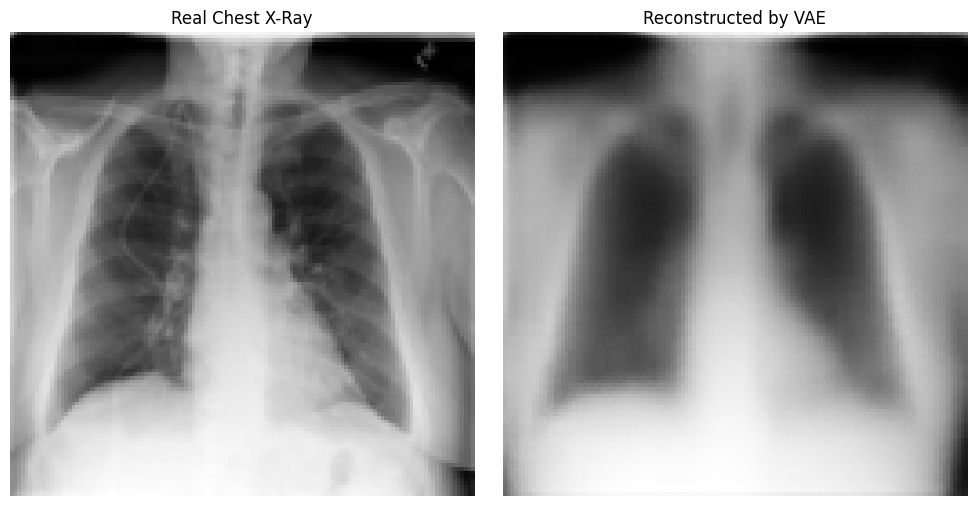

In [27]:
# Get real and reconstructed images
X, X_rec, _ = trainer.inference(test_dataloader)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(X[0].reshape(128, 128), cmap="gray")
ax1.set_title("Real Chest X-Ray")
ax1.axis('off')

ax2.imshow(X_rec[0].reshape(128, 128), cmap="gray")
ax2.set_title("Reconstructed by VAE")
ax2.axis('off')

plt.tight_layout()
plt.savefig("chestxray_vae_comparison.png", dpi=150)
plt.show()

## Experiment 2: Random Image Generation

Once the VAE has been trained, we can use it to generate new random chest X-Ray images. Results will be better if the model is trained for more epochs.

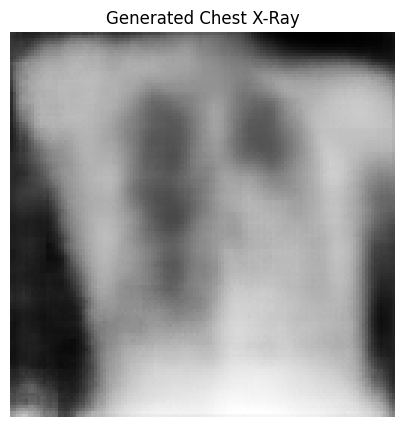

In [28]:
# Generate synthetic images
model = trainer.model
model.eval()

with torch.no_grad():
    # Sample from latent space
    z = torch.randn(1, model.hidden_dim).to(model.device)
    
    # Reshape for decoder (add spatial dims)
    z = z.unsqueeze(2).unsqueeze(3)
    
    # Generate image
    generated = model.decoder(z).detach().cpu().numpy()
    
    # Plot
    plt.figure(figsize=(5, 5))
    plt.imshow(generated[0].reshape(128, 128), cmap="gray")
    plt.title("Generated Chest X-Ray")
    plt.axis('off')
    plt.savefig("chestxray_vae_synthetic.png", dpi=150)
    plt.show()

## New Feature: Conditional VAE

We  can use the VAE to generate random images, conditioned of patient features, such as diagnosis codes etc.

In this example, we only have two patients, so the results will be quite poor.

In [29]:
# Create dataset with conditional features
samples_with_conditions = [
    {
        "patient_id": "patient-0",
        "visit_id": "visit-0",
        "path": torch.rand(3, 128, 128),  # Dummy image
        "conditions": ["COVID-19", "pneumonia"],
        "label": 0,
    },
    {
        "patient_id": "patient-1",
        "visit_id": "visit-1",
        "path": torch.rand(3, 128, 128),
        "conditions": ["normal"],
        "label": 1,
    },
]

from pyhealth.datasets import SampleDataset

cond_dataset = SampleDataset(
    samples=samples_with_conditions,
    input_schema={"path": "tensor", "conditions": "sequence"},
    output_schema={"label": "binary"},
    dataset_name="conditional_demo",
)

# Conditional VAE model
cond_model = VAE(
    dataset=cond_dataset,
    feature_keys=["path"],
    label_key="label",
    mode="binary",
    input_type="image",
    input_channel=3,
    input_size=128,
    hidden_dim=64,
    conditional_feature_keys=["conditions"],
)

print("Conditional VAE created with embedding model for conditions")
print(f"Has embedding model: {hasattr(cond_model, 'embedding_model')}")

Label label vocab: {0: 0, 1: 1}


Processing samples:   0%|          | 0/2 [00:00<?, ?it/s]/home/ubuntu/PyHealth/pyhealth/processors/tensor_processor.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, dtype=self.dtype)
Processing samples: 100%|██████████| 2/2 [00:00<00:00, 175.85it/s]

Conditional VAE created with embedding model for conditions
Has embedding model: True


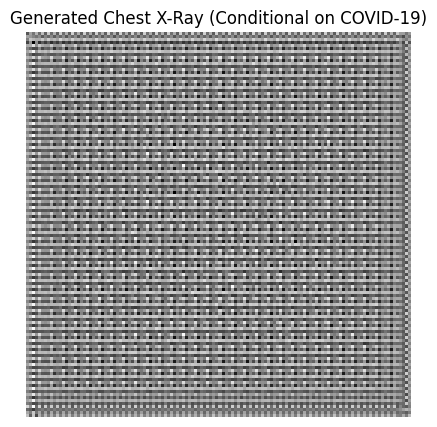

In [30]:

# Generate conditional images
cond_model.eval()
with torch.no_grad():
    # Sample from latent space
    z = torch.randn(1, cond_model.hidden_dim).to(cond_model.device)

    # Create conditional data - need to process it like the dataset does
    # For sequence data, convert to tensor indices using the dataset's vocabulary
    vocab = cond_dataset.input_processors["conditions"].code_vocab
    condition_indices = [vocab.get(code, vocab.get("<unk>", 0)) for code in ["COVID-19"]]
    cond_data = {"conditions": torch.tensor(condition_indices, dtype=torch.long).unsqueeze(0)}  # (1, seq_len)

    # Now get embeddings
    cond_embeddings = cond_model.embedding_model(cond_data)
    cond_vec = cond_embeddings["conditions"].mean(dim=1)  # Average pooling for sequence

    # Reshape for decoder
    z = z.unsqueeze(2).unsqueeze(3)

    # Add conditional information to latent space
    z = z + cond_vec.unsqueeze(2).unsqueeze(3)

    # Generate image
    generated = cond_model.decoder(z).detach().cpu().numpy()

    # Plot - handle multi-channel output
    plt.figure(figsize=(5, 5))
    if generated[0].shape[0] == 3:  # RGB image
        img_to_show = generated[0].mean(axis=0)
    else:
        img_to_show = generated[0].reshape(128, 128)

    plt.imshow(img_to_show, cmap="gray")
    plt.title("Generated Chest X-Ray (Conditional on COVID-19)")
    plt.axis('off')
    plt.savefig("chestxray_vae_conditional.png", dpi=150)
    plt.show()